# TP Active Contour
## Par Abdennour Kerboua (fait seul)

In [1]:
import numpy as np
import matplotlib
import skimage
import IPython

import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour # For active_contour function
from skimage.util import random_noise

# For active_contour function
from skimage.segmentation import chan_vese, morphological_chan_vese, checkerboard_level_set,morphological_geodesic_active_contour

# For some image filtering
from skimage.morphology import white_tophat, black_tophat, disk

import skimage.io

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# PRINT VERSIONS
print("np.__version__",np.__version__)
print("matplotlib.__version__",matplotlib.__version__)
print("skimage.__version__",skimage.__version__)
print("IPython.__version__",IPython.__version__)


np.__version__ 1.26.4
matplotlib.__version__ 3.10.0
skimage.__version__ 0.25.0
IPython.__version__ 7.34.0


In [ ]:
def edge_map(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.sobel(blur)

def edge_map2(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.scharr(blur)

def subtract_background(image, radius=5, light_bg=False):
        str_el = disk(radius)
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)


def define_initial_circle(R0,r0,c0,Nber_pts=400):
    # Define initial contour shape
    s      = np.linspace(0, 2*np.pi, Nber_pts)
    Radius = R0
    r      = r0 + Radius*np.sin(s)
    c      = c0 + Radius*np.cos(s) #col
    init   = np.array([r, c]).T
    return init


## Create slides for animation
def animate_cv(image, segs, interval=1000):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray');
    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    ax.axis('off')

    def init():
        im.set_data(segs[0])
        return [im]

    def animate(i):
        im.set_array(segs[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim


def animate_snake(image, segs, interval=500):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray');
    #    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    #ax.plot(segs[0][:, 1], segs[0][:, 0], '--r', lw=3)
    ax.axis('off')
    line, = ax.plot([], [], '-r', lw=2)

    def init():
        line.set_data(segs[0,:,1],segs[0,:,0])
        return [line,]

    def animate(i):
        line.set_data(segs[i,:,1],segs[i,:,0])
        return [line,]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim



###########################
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

# Read images

This part reads a series of images that you can then use in various tests. <br>
Note that some images are provided with ground-truth masks of structures of interest:<br>
1. OCT_tissue
2. CTabd (CT of the abdomen)
3. US nodule (Ultrasound image with a nodule)
4. images_blood_cells/000016.png [several images available]


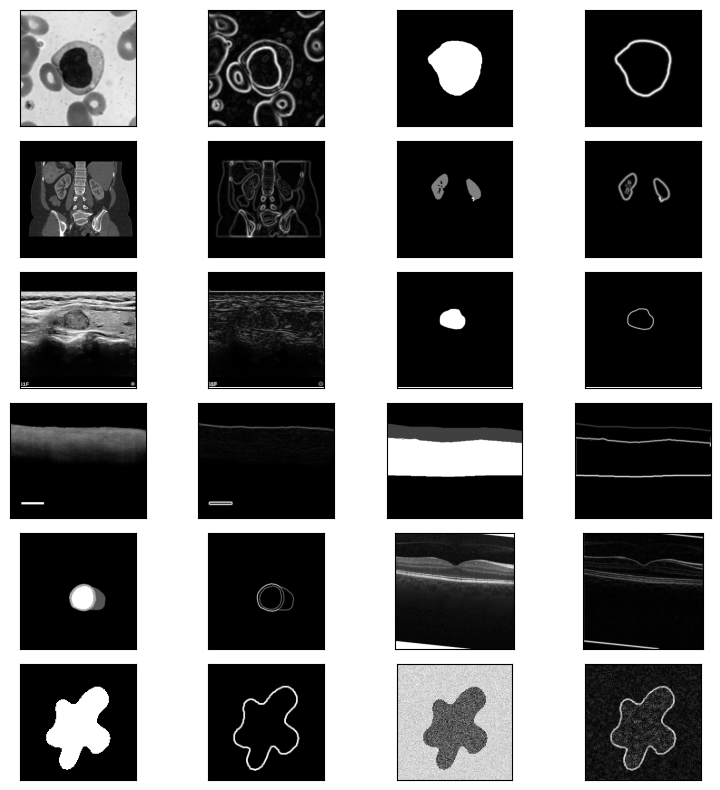

In [ ]:
# import warnings
# warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
# skimage.io.imshow(img_mask)

# Binary images  - w/o ground truth
img_star          = skimage.io.imread('./images_misc/smooth_star.png', as_gray = True)
edge_star         = edge_map(img_star, sigma=0)
img_star_noisy    = skimage.io.imread('./images_misc/smooth_star_noisy.png', as_gray = True)
edge_star_noisy   = edge_map(img_star_noisy, sigma=0)
img_binshape      = skimage.io.imread('./images_misc/binary_shape_2024.png', as_gray = True)
edge_binshape     = edge_map(img_binshape, sigma=0)
img_cardiacshape  = skimage.io.imread('./images_misc/cardiac_mri_mask.png', as_gray = True)
edge_cardiacshape = edge_map(img_cardiacshape, sigma=0)


# OCT eye images  - w/o ground truth
img_oct_eye  = skimage.io.imread('./images_misc/OCT_normal.jpeg', as_gray = True)
img_oct_eye  = np.squeeze(img_oct_eye)
img_oct_eye  = img_oct_eye.astype('float64')
img_oct_eye  = img_oct_eye/np.max(img_oct_eye)

edge_oct_eye = edge_map(img_oct_eye, sigma=2)

# CT abdo images  - with ground truth
img_CTabd     = skimage.io.imread('./images_misc/CT_kidney_im.png', as_gray = True)
edge_CTabd    = edge_map(img_CTabd, sigma=2)
gt_CTabd      = skimage.io.imread('./images_misc/CT_kidney_mask.png', as_gray = True)
edge_gt_CTabd = edge_map(gt_CTabd, sigma=2)


# Cell images  - with ground truth
img_cell  = skimage.io.imread('./images_blood_cells/0000152.png', as_gray = True)
edge_cell = edge_map(img_cell, sigma=2)
#skimage.io.imshow(img_cell)
gt_cell = skimage.io.imread('./masks_blood_cells/0000152.png', as_gray = True)
edge_gt_cell = edge_map(gt_cell, sigma=2)


# OCT image of tissue  - with ground truth
img_oct_tissue  = skimage.io.imread('./OCT_myocardium/case272.tif', as_gray = True)
edge_oct_tissue = edge_map(img_oct_tissue, sigma=2)
gt_oct_tissue  = skimage.io.imread('./OCT_myocardium/case272_label.tiff', as_gray = True)
edge_gt_oct_tissue = edge_map(gt_oct_tissue, sigma=2)

# US image of a nodule  - with ground truth
img_USnodule  = skimage.io.imread('./thyroid_nodule/1074.png', as_gray = True)
edge_USnodule = edge_map(img_USnodule, sigma=2)
gt_USnodule   = skimage.io.imread('./thyroid_nodule/1074_mask.png', as_gray = True)
edge_gt_USnodule = edge_map(gt_USnodule, sigma=2)

# PLOTS

fig, axes = plt.subplots(6,4, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(img_cell, cmap=plt.cm.gray);
ax[1].imshow(edge_cell, cmap=plt.cm.gray);
ax[2].imshow(gt_cell, cmap=plt.cm.gray);
ax[3].imshow(edge_gt_cell, cmap=plt.cm.gray);

ax[4].imshow(img_CTabd, cmap=plt.cm.gray);
ax[5].imshow(edge_CTabd, cmap=plt.cm.gray);
ax[6].imshow(gt_CTabd, cmap=plt.cm.gray);
ax[7].imshow(edge_gt_CTabd, cmap=plt.cm.gray);

ax[8].imshow(img_USnodule, cmap=plt.cm.gray);
ax[9].imshow(edge_USnodule, cmap=plt.cm.gray);
ax[10].imshow(gt_USnodule, cmap=plt.cm.gray);
ax[11].imshow(edge_gt_USnodule, cmap=plt.cm.gray);

ax[12].imshow(img_oct_tissue, cmap=plt.cm.gray);
ax[13].imshow(edge_oct_tissue, cmap=plt.cm.gray);
ax[14].imshow(gt_oct_tissue, cmap=plt.cm.gray);
ax[15].imshow(edge_gt_oct_tissue, cmap=plt.cm.gray);

ax[16].imshow(img_cardiacshape, cmap=plt.cm.gray);
ax[17].imshow(edge_cardiacshape, cmap=plt.cm.gray);

ax[18].imshow(img_oct_eye, cmap=plt.cm.gray);
ax[19].imshow(edge_oct_eye, cmap=plt.cm.gray);

ax[20].imshow(img_star, cmap=plt.cm.gray);
ax[21].imshow(edge_star, cmap=plt.cm.gray);
ax[22].imshow(img_star_noisy, cmap=plt.cm.gray);
ax[23].imshow(edge_star_noisy, cmap=plt.cm.gray);

for i in range(0,24):
    ax[i].set_xticks([]), ax[i].set_yticks([]);
fig.tight_layout()
plt.show();


# Image properties:
## Range of values and data type matter ...


Some routines won't work if your image type is int8 or uint8...
Here is how to check your image data type

And regularly check your image content in terms of:
* intensities range of values
* distributions of intensities via its histogram


Data type of img_test is:  uint8
min - max value in image: 0 255


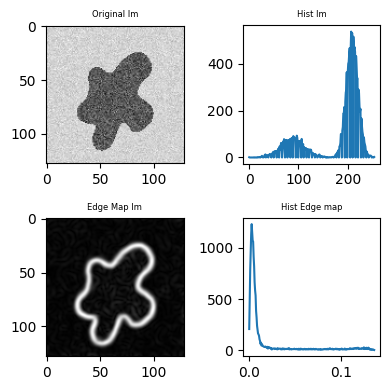

In [ ]:

img_test  = img_star_noisy#img_oct_eye #img_CTabd #img_cell
Sigma_val = 2
edge_test = edge_map(img_test, sigma=Sigma_val)


## Print some basic image properties
print("Data type of img_test is: ", img_test.dtype)
print("min - max value in image:" , np.min(img_test), np.max(img_test))


## Hot to plot a Histogram
hist_test, bins_test             = np.histogram(img_test.flatten(), bins=256)
hist_edge_test, bins_edges_test  = np.histogram(edge_test.flatten(), bins=256)

fig, axes = plt.subplots(2,2, figsize=(4, 4))
ax        = axes.ravel()
ax[0].imshow(img_test, cmap=plt.cm.gray);
ax[0].set_title("Original Im", fontsize=6);
ax[1].plot(bins_test[0:-1],hist_test);
ax[1].set_title("Hist Im", fontsize=6);
ax[2].imshow(edge_test, cmap=plt.cm.gray);
ax[2].set_title("Edge Map Im", fontsize=6);
ax[3].plot(bins_edges_test[0:-1],hist_edge_test);
ax[3].set_title("Hist Edge map", fontsize=6);
fig.tight_layout()
plt.show();



# Edge maps
Deformable models rely on edge maps. Most routines have their own strategy coded to compute the edge map.

* Edge maps usually involve smoothing of the image, to be robust to noise. Make sure you understand how this is controlled in the routine you use.
* Edge maps usually show pixels with high gradient magnitudes in white (high values)
* Most deformable model routines can be fed directly with an Edge Map rather than the original image as its input
* Some routine expect to be fed with an inverse edge map where high gradient locations have small values, to stop the contour via a velocity set to ~zero.

Data type of img_test is:  uint8
min - max value in image: 0 255


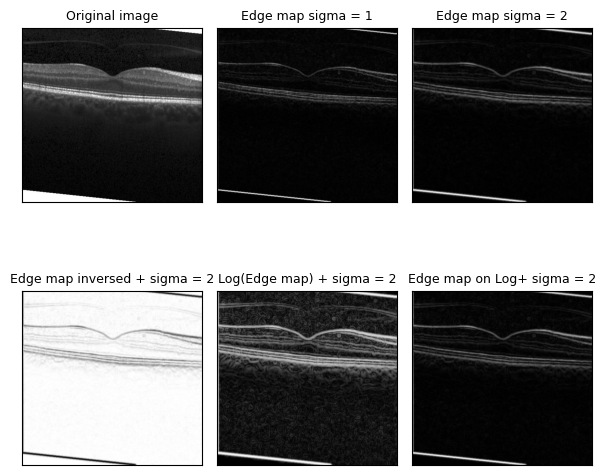

In [ ]:

img_to_test = img_oct_eye
print("Data type of img_test is: ", img_test.dtype)
print("min - max value in image:" , np.min(img_test), np.max(img_test))

Font_size  = 9

# Classic Edge map with Gaussian smoothing controled by sigma
edge_test1         = edge_map(img_to_test, sigma=1)
edge_test2         = edge_map(img_to_test, sigma=2)
edge_test2_l       = np.log2((edge_test2*100)+1)
edge_testl_2       = edge_map(np.log2((img_to_test+1)*100), sigma=2)

# Inversed Edge map
# Returns Edge map = 1.0 / np.sqrt(1.0 + alpha * gradnorm)
edge_inv_test  = skimage.segmentation.inverse_gaussian_gradient(img_to_test, alpha=1.0, sigma=2.0)


fig, axes = plt.subplots(2,3, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(img_to_test, cmap=plt.cm.gray);
ax[0].set_title("Original image", fontsize=Font_size);
ax[1].imshow(edge_test1, cmap=plt.cm.gray);
ax[1].set_title("Edge map sigma = 1", fontsize=Font_size);
ax[2].imshow(edge_test2, cmap=plt.cm.gray);
ax[2].set_title("Edge map sigma = 2", fontsize=Font_size);
ax[3].imshow(edge_inv_test, cmap=plt.cm.gray);
ax[3].set_title("Edge map inversed + sigma = 2", fontsize=Font_size);
ax[4].imshow(edge_test2_l, cmap=plt.cm.gray);
ax[4].set_title("Log(Edge map) + sigma = 2", fontsize=Font_size);
ax[5].imshow(edge_testl_2, cmap=plt.cm.gray);
ax[5].set_title("Edge map on Log+ sigma = 2", fontsize=Font_size);

for i in range(0,6):
    ax[i].set_xticks([]), ax[i].set_yticks([]);

fig.tight_layout()
plt.show();

# Image transforms

Let you test some image transformations based on morphological operators and histogram manipulation.
When transforming image contrast, it is always interesting to look at the differences between the original image and the transformed version.

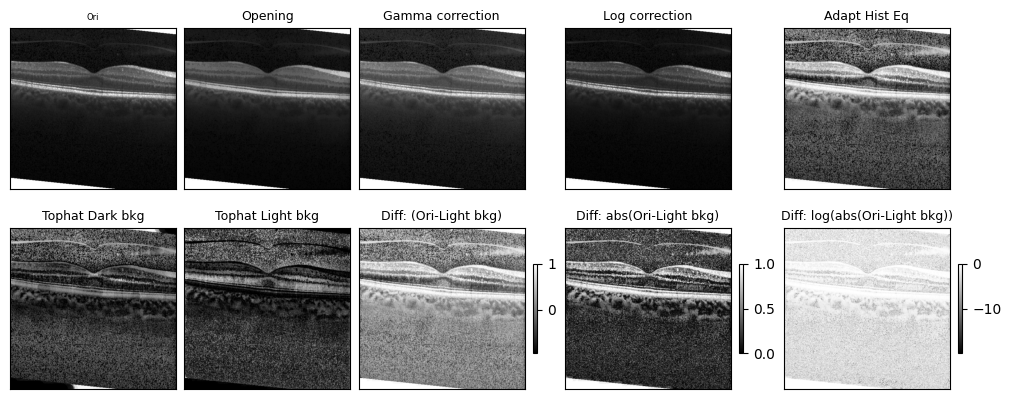

In [ ]:
img_ori_to_test = img_oct_eye #img_CTabd
img_to_test     = img_ori_to_test
epsilon         = 0.000001 #to prevent log on 0
img_eps         = np.full_like(img_to_test, epsilon)
PRE_ENHANCE     = 1
OPTION_ENHANCE  = 4 # can be 0 (nothing) OR 1,2,3,4 for different enchancement options
Font_size  = 9

# Run all  OPTION_ENHANCE for display here
gamma_corrected       = skimage.exposure.adjust_gamma(img_to_test, 0.8)
logarithmic_corrected = skimage.exposure.adjust_log(img_to_test, gain= 1,inv=True)
img_open              = skimage.morphology.diameter_opening(img_to_test, 40, connectivity=2)
img_adapteq           = skimage.exposure.equalize_adapthist(img_to_test, clip_limit=0.03)

# PRE ENHANCEMENT OPTIONS:
if PRE_ENHANCE==1:
    if OPTION_ENHANCE==1:
        # Gamma
        img_to_test     = gamma_corrected
    elif OPTION_ENHANCE==2:
        # Logarithmic (O = gain*log(1 + I)) or if Inv (O = gain*(2**I - 1))
        img_to_test           = logarithmic_corrected
    elif OPTION_ENHANCE==3:
        # Morpho Opening
        img_to_test           = img_open
    elif OPTION_ENHANCE==4:
        # Contrast Limited Adaptive Histogram Equalization (CLAHE).
        img_to_test           = img_adapteq

# Enhance details either dark around light background of vice versa with the Top-Hat transform
Radius_val = 15
img_test1  = subtract_background(img_to_test, radius=Radius_val, light_bg=False)
img_test2  = subtract_background(img_to_test, radius=Radius_val, light_bg=True)

# SHOW OUTPUTS
fig, axes = plt.subplots(2,5, figsize=(10, 4),constrained_layout=True)
ax        = axes.ravel()
Shrink_factor_colormap = 0.5
ax[0].imshow(img_ori_to_test, cmap=plt.cm.gray);
ax[0].set_title("Ori", fontsize=6);

ax[1].imshow(img_open, cmap=plt.cm.gray);
ax[1].set_title("Opening", fontsize=Font_size);
ax[2].imshow(gamma_corrected, cmap=plt.cm.gray);
ax[2].set_title("Gamma correction", fontsize=Font_size);
ax[3].imshow(logarithmic_corrected, cmap=plt.cm.gray);
ax[3].set_title("Log correction", fontsize=Font_size);
ax[4].imshow(img_adapteq, cmap=plt.cm.gray);
ax[4].set_title("Adapt Hist Eq", fontsize=Font_size);

ax[5].imshow(img_test1, cmap=plt.cm.gray);
ax[5].set_title("Tophat Dark bkg", fontsize=Font_size);
ax[6].imshow(img_test2, cmap=plt.cm.gray);
ax[6].set_title("Tophat Light bkg", fontsize=Font_size);

tmp_show = ax[7].imshow(img_to_test-img_test2, cmap=plt.cm.gray);
ax[7].set_title("Diff: (Ori-Light bkg)", fontsize=Font_size);
plt.colorbar(tmp_show,ax=ax[7], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[8].imshow(abs(img_to_test-img_test2), cmap=plt.cm.gray);
ax[8].set_title("Diff: abs(Ori-Light bkg)", fontsize=Font_size);
plt.colorbar(tmp_show,ax=ax[8], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[9].imshow(np.log2(abs(img_to_test-img_test2+img_eps)), cmap=plt.cm.gray);
ax[9].set_title("Diff: log(abs(Ori-Light bkg))", fontsize=Font_size);
plt.colorbar(tmp_show,ax=ax[9], shrink=Shrink_factor_colormap, location='right')

for i in range(0,10):
    ax[i].set_xticks([]), ax[i].set_yticks([]);

#fig.tight_layout() # not compatible with option constrained_layout=True in plt.subplots needed to display the colorbar
plt.show();


# Seg #1:
### Snake on a binary shape + noise effects

This part of the practical work uses the routine **active_contour** from skimage. <br>
Default **parameter values** are: <br>
* alpha=0.01  (Snake length shape parameter. Higher values makes snake contract faster.)
* beta=0.1    (Snake smoothness shape parameter. Higher values makes snake smoother.)
* gamma=0.01  (Explicit time stepping parameter - Equivalent to the viscosity of the environment)
* max_px_move=1.0
<br>

There are two **other parameters** that define the final image information used to define external forces used to define regions.img = w_line x img + w_edge x edge: <br>
*   w_line_val= 0 (default) | =1 if want to input_edge map directly. Use negative values to attract toward dark
*   w_edge_val= 1 (default)  | = 0 if do not want to use internal edge map. Use negative values to repel snake from edges


## TODO:
**Provide answers in text boxes**
***
__Q1.1__. Run the code for **img_to_seg=img_cardiacshape** using **img_ori** and all parameter values as provided, except for changing the R0 value.
Comment on behavior for:<br>

- R0=10: Le contour n'évolue quasiment pas après 10 itérations (évolution identique qu'à la première itération). Après 1800 itérations, le contour évolue en s'éloignant des contours de la cellule, car le contour initial est trop éloigné des contours réels pour en être attiré et l'évolution par défaut est faite pour réduire la taille du contour. Le contour est attiré par un minimum local. <br>

- R0=20: 10 itérations ne suffisent qu'à aligner que la partie de l'active contour la plus proche du contour réel. Après 1800 itérations, le contour s'aligne avec le premier contour réel qu'il rencontre : le contour de la partie intérieure blanche. <br>

- R0=30: Cette fois après 1800 itérations, le contour s'aligne sur le coutour externe incluant la zone gris clair.  <br>

- R0=50:  Cette fois le contour est trop grand et englobe deux objets différents.
***
***
__Q1.2__. For R0=30 test the segmentation without smoothing and then with Niter_smooth = 1 and 2. Comment on the segmentation quality for: <br>
- no smoothing: Le contour final est très irrégulier ($\frac{\partial \nu}{\partial s}$ élevé) et ne délimite pas parfaitement l'objet.  
- Niter_smooth = 1: Le contour final est plus régulier et cette fois délimite mieux le contour.
- Niter_smooth = 2: Le contour est encore plus régulier, délimite parfaitement l'objet mais n'est pas fermé.
***
***
__Q1.3__. Now run the segmentation on the **noisy version** or the image. 2 types of noise are simulated: (1) Additive Gaussian noise, (2) Speckle (multiplicative) noise. <br>
__Q1.3.1__ Check **appearance** of the 2 noisy images. Why is there no noise in the background in the speckle case? <br>
__Answer__:
<br>
__Q1.3.2__ Using **R0=50**, run the segmentation on the noisy images **without** and with **smoothing** (Niter_smooth= 1). Comment on segmentation quality or issues for the 4 observations:  
- Speckle noise + no smoothing: La segmentation est très irrégulière et la segmentation non précise : une partie délimite le contour réel externe incluant la partie gris clair et une autre le contour réel interne entourant la partie blanche. <br>
- Speckle noise +  smoothing: La régularité et la qualité de la segmentation sont amélioré. La segmentation délimite un seul objet : le contour externe de la cellule. <br>
- Gaussian noise + no smoothing: La segmentation est très irrégulière et la segmentation non précise : une partie délimite le contour réel externe incluant la partie gris clair et une autre le contour réel interne entourant la partie blanche. La méthode est sensible aux minimums locaux et dépend grandement de l'initialisation. <br>
- Gaussian noise +  smoothing: La régularité et la qualité de la segmentation sont amélioré. La segmentation délimite un seul objet : le contour externe de la cellule. <br>
***

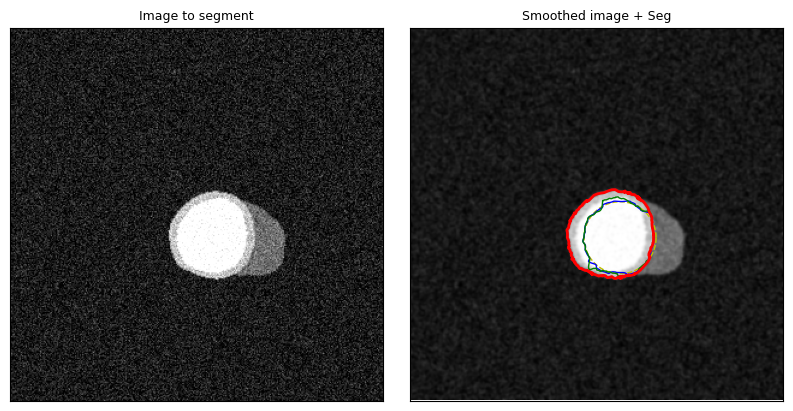

In [ ]:
# 1ST image
img_ori          = img_cardiacshape; r0 = 175; c0=175; R0 = 30
img_noisy_1        = random_noise(img_ori, mode='gaussian', mean = 0.1,clip = True)
img_noisy_2       = random_noise(img_ori, mode='speckle', mean = 0.1,clip = True)

# Choose image to segment
img_to_seg     = img_noisy_1
img_to_seg_raw = img_to_seg # to plot later on

alpha_val  = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
convergence_val = 1e-4;Niter_snake = 1800;


# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Pre-smooth the image
Niter_smooth    = 1 # set to 0 for no smoothing
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour
snake1  = active_contour(img_to_seg,
                       init, max_num_iter=1, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake10 = active_contour(img_to_seg,
                       init, max_num_iter=10, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake_max = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val,
                           alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results
fig, axes = plt.subplots(1,2, figsize=(8, 4),constrained_layout=True)
ax        = axes.ravel()
Font_size = 9
ax[0].imshow(img_to_seg_raw, cmap=plt.cm.gray);
ax[0].set_xticks([]), ax[0].set_yticks([]);
ax[0].set_title("Image to segment", fontsize=Font_size);

ax[1].imshow(img_to_seg, cmap=plt.cm.gray);
ax[1].plot(init[:, 1], init[:, 0], '--y', lw=1);
ax[1].plot(snake10[:, 1], snake1[:, 0], '-b', lw=1);
ax[1].plot(snake10[:, 1], snake10[:, 0], '-g', lw=1);
ax[1].plot(snake_max[:, 1], snake_max[:, 0], '-r', lw=2);
ax[1].set_xticks([]), ax[1].set_yticks([]);
ax[1].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
ax[1].set_title("Smoothed image + Seg", fontsize=Font_size);

plt.show();

# Seg #2:
### Snake on Cell image

We are using here **img_to_seg   = img_cell** for which you have a ground truth mask **gt_cell** of the target segmentation for the bright right cell.  

## TODO
***
__Q2.1__ **Segment large right  cell**:
Run with code as provided and check quality of the segmentation versus the ground-truth. Did it work? <br>
**Answer**: La segmentation a correctement fonctionné et produit un contour quasi-identique à la segmentation but **gt_cell**.
 <br>
***
***

__Q2.2__ Now aiming to segment the internal dark part of the cell: change only values for Niter_smooth and R0 and propose a solution that works. <br>
**Answer**: managed to obtain a correct segmentation with Niter_smooth = 2 and R0 = 40 <br>
***

***
__Q2.3__ **Segment small left cell**:
Run with the proposed initialisation and check correct segmentation of the whole left cell.
Now change ONLY some initial contour parameter(s) **\[r0 = 153; c0=66; R0 = 25\]** to obtain a perfect segmentation of the internal bright center of the cell. <br>
**Answer**: managed to obtain a correct segmentation with \[r0 = 153; c0=66; R0 = 12\] <br>
***



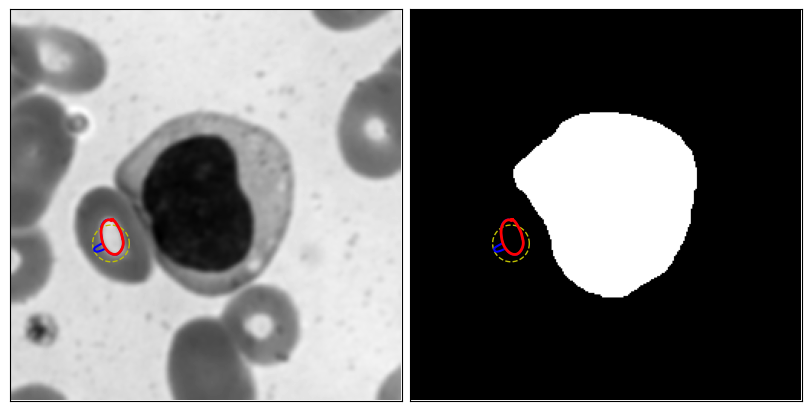

In [ ]:

# Input image and parameter values
img_to_seg   = img_cell;
img_gt       = gt_cell;

#Large rigt cell - ground truth provided
#r0 = 128; c0=128; R0 = 40
# Small left cell - no ground truth
r0 = 153; c0=66; R0 = 12


alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 1200;


# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)


# Initialise contour
init = define_initial_circle(R0,r0,c0)

# Run active contour
snake30 = active_contour(img_to_seg,
                       init, max_num_iter=30, convergence=convergence_val,
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results
fig, axes = plt.subplots(1,2, figsize=(8, 4),constrained_layout=True)
ax        = axes.ravel()
Font_size = 9

ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
ax[0].plot(init[:, 1], init[:, 0], '--y', lw=1)
ax[0].plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax[0].plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax[0].set_xticks([]), ax[0].set_yticks([])
ax[0].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

ax[1].imshow(img_gt, cmap=plt.cm.gray)
ax[1].plot(init[:, 1], init[:, 0], '--y', lw=1)
ax[1].plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax[1].plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax[1].set_xticks([]), ax[1].set_yticks([])
ax[1].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

# Seg # 3

### A tool to visualise the deformations of the snake over iterations


## TO DO:
Run the code with provided parameter values. <br>
***
__Q3.1__ Checking the video, would you confirm that the snake has converged and is stable?<br>
**Answer**: La méthode converge bien vers le minimum d'énergie : les variations du contour deviennent de moins en moins importante au fur et à mesure que l'active contour se rapproche du contour réel. Elle est aussi stable car lorsqu'un point de l'active contour arrive sur le contour réel reste fixe le reste de la simulation. <br>

***

__Q3.2__ Change R0 to R0 = 52. Has convergence time been shorter or longer? Did you expect such observation (yes/no)? <br>
**Answer**: Le temps de convergence est sensiblement plus grand. Ce qui était prévisible car l'état initial du contour est plus éloigné du minimum d'énergie pour $R_0 = 52$ que pour $R_0 = 53$.  <br>

start
1  21  41  61  81  101  121  141  161  181  201  221  241  261  281  301  321  341  361  381  401  421  441  461  481  501  521  541  561  581  601  621  641  661  681  701  721  741  761  781  stop


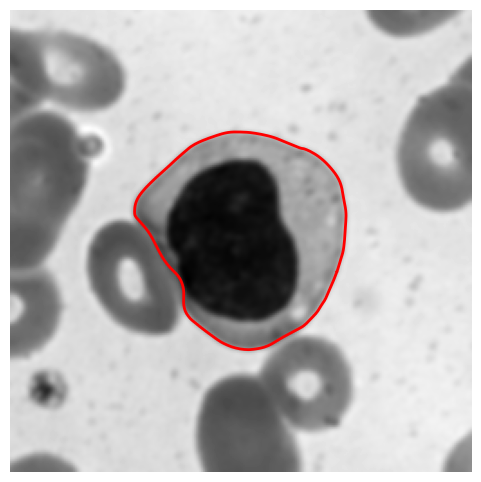

In [ ]:
img_to_seg        = img_cell
img_to_seg_ori    = img_to_seg

# Init to segment cell
r0 = 128; c0=128; R0 = 52
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 800;



# Pre filter the image
img_adapteq = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)
#img_to_seg = img_adapteq

# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour
init = define_initial_circle(R0,r0,c0)


# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,20):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

# Seg # 4

### Snake with  Gradient Vector Flow (GVF)
This implementation of the GVF is performed by computing the edge map, diffusing the gradient over the whole image and directly input the GVF_edge_map to be used as external forces by setting w_line=1 and w_edge=0 in the active_contour function.

## TODO:
***
__Q4.1.1__ Report the visual differences in the GVF_map between mu=5 and mu=15. <br>
**Answer**: Pour $\mu = 5$, le gradient n'est élevé que sur une fine bordure non fermé, discontinue. Alors que pour $\mu = 15$, le gradient s'est beaucoup plus diffusé et est très élevé (case blanches) sur une bordure plus épaisse et parfaitement continue. <br>

__Q4.1.2__ What is the mu parameter controling? <br>
**Answer**: Le paramètre $\mu$ contrôle la régularité du champ de gradient. <br>
***
***
__Q4.2__ Why does mu=15 enable to obtain a correct segmentation? <br>
**Answer**: $\mu = 15$ permet d'avoir une carte de champ gradient continue et régulière, très élevée autour des contours, où le gradient est bien diffusé. Le contour est attiré par les régions de gradient élevé et converge donc très rapidement vers le maximum du gradient et donc le minimum d'énergie. <br>
***
***
__Q4.3__ Report what happens when segmenting with the classic Edge_map rather than the GVF_map. <br>
**Answer**: Le gradient n'étant pas diffusé, une partie de l'active contour reste à distance du minimum d'énergie car elle est trop éloigné du lieu où le gradient est maximal et ne peut donc y être attiré. <br>
***

................................................................................................................................
start
1  11  21  31  41  51  61  71  81  91  101  111  121  131  141  151  161  171  181  191  stop


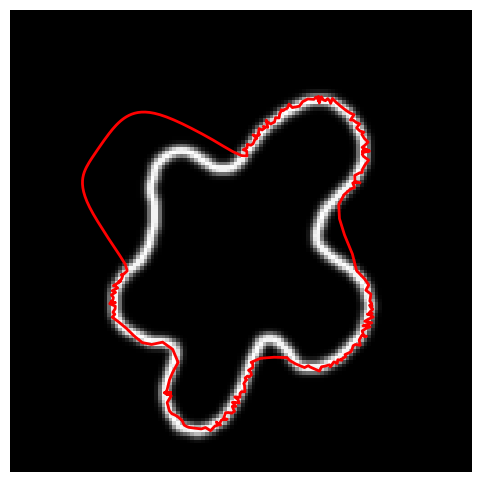

In [ ]:
import gvf_elsa2
from gvf_elsa2 import  gradient_field, gradient_vector_flow


# Image to seg
img_to_seg = img_star
r0 = 64; c0=64; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 200;


# Initialise contour
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg)
gx, gy = gradient_vector_flow(fx, fy, mu=4)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_num_iter=i, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

# Seg # 5:

### The active contour with fixed end points
You will now run the active_contour with the option to maintain some points from the inital contour fixed. You are working with the **img_oct_eye** which shows different layers of the retina. The **active_contour** routine is called to used directly the **Edge_map** as input.   

## TO DO:
***
__Q5.1__ Rank the 4 options for the Edge_map options from top to worst to segment the two layers wrt to segmentation quality and robustness to leyer selection.   <br>
__Answer__: Ranked Edge_map options from best to worst: <br>
1. edge_testl_2 <br>
2. edge_test2 <br>
3. edge_test1 <br>
4. edge_test2_l <br>

***

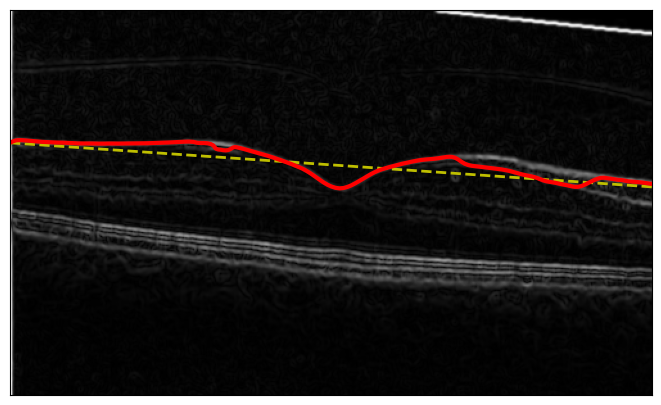

In [ ]:

img_to_seg = img_oct_eye

# init for 1st layer
r_left = 103; r_right=138; c_left=0; c_right = 510
# init for 2nd layer
#r_left = 158; r_right=204; c_left=0; c_right = 510


alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01;
convergence_val = 1e-4; Niter_snake = 500;
w_line_val=1; w_edge_val=0;

# Computation of edge maps
edge_test1         = edge_map(img_to_seg, sigma=1)
edge_test2         = edge_map(img_to_seg, sigma=2)
edge_test2_l       = np.log2((edge_test2*100)+1)
edge_testl_2       = edge_map(np.log2((img_to_seg+1)*100), sigma=2)

# Selection of edge_map to use
Edge_map           = edge_test1

# Initialise contour
Nber_pts_contour = 200
r          = np.linspace(r_left, r_right, Nber_pts_contour)
c          = np.linspace(c_left, c_right, Nber_pts_contour)
init       = np.array([r, c]).T


snake = active_contour(Edge_map,
                       init, boundary_condition='fixed-fixed',max_num_iter=Niter_snake,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                       w_line=w_line_val, w_edge=w_edge_val)


# FIGURE

fig, ax = plt.subplots(figsize=(9, 5));
ax.imshow(Edge_map[0:300,:], cmap=plt.cm.gray);
ax.plot(init[:, 1], init[:, 0], '--y', lw=2);
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=3);
ax.set_xticks([]), ax.set_yticks([]);
ax.set(xlim=(0, 500));
plt.show();

# Seg # 6
BONUS - Optional
### Your turn on proposing a motivated pipeline using the snake capabilities from the active_contour function

## TODO:
Choose a new image in the pool provided and propose a segmentation pipeline using the active_contour approach. Options on points to work on include: <br>
* Pre-filter the image as you wish
* Manually or automatically position the initial contour
* Provide one segmentation result or merge several solutions in a probability map
* Detect issues in contour shape during deformations and propose an early stop criteria.


***
__Q6__ Provide  code + visual illustrations of results <br>
__Answer__
***

# Seg #7

### Test on the Geometric Level-Set formulation using the Chan-Vese model.
Skimage provides two implementations of the Chan-Vese approach: **morphological_chan_vese** and **chan_vese**. <br>

The contours of ojects are now encoded in a level set function **Phi**.

The **initialisation** tested here is with a "checkerboard" pattern for 2 classes (object and background). <br>

For the **chan_vese** original implementation, the **hyper-parameters** include:<br>
* mu = 0.25 (default) | edge regularisation terms. Similar to ‘edge length’ weight parameter. Higher mu values will produce ‘smoother’ contours.
* dt = 0.5 (default) |  delta time step for each optimisation step.  
* lambda1=1, lambda2=1 (default) | weights in the cost metric to balance inside and outside homogeneity terms.
* tol=1e-3 (default) | Tolerance to test if the contours are "stable" and stop early.

The output contains: cv[0]=Seg and cv[1]=Phi <br>

For the **morphological_chan_vese**  implementation, the only **hyper-parameter** is the number of smoothing iterations (1 to 4 recommended).<br>

## TO DO:
1. C-V ori: Run the code on img_hela. Visualise and explain  evolution of Phi over first iterations. Figure out how to see the initial Phi configuration.
1. Run now on img_cell without and with pre-processing with histogram equalisation and explain difference in results.
1. Propose and implement method(s) and metrics to compare two segmentation results when handling segmentation masks. Use the one(s) implemented to quantify the differences obtained on one test case of your choice with the two implementations of chan-vese provided here.
1. Make the level set work when initialising with "disk" on img_MRIf


In [ ]:

img_to_seg= img_hela

# PARAMETERS
mu_val=0.5 ; lambda1_val=1; lambda2_val=1; tol_val=1e-3; dt_val=0.5
smoothing_val = 3

Num_iter_cv_ori    = 100
Num_iter_cv_fast   = 1

CHAN_VESE_ORI  = 1
Init_method    = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper
    init_ls = checkerboard_level_set(img_to_seg.shape, 45)

    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val,
                   max_num_iter=Num_iter_cv_ori, init_level_set=Init_method,
                   extended_output=True)
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V with - {len(cv[2])} iterations'
    ax[1].set_title(title, fontsize=12)

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_fast,
                                      smoothing=smoothing_val, init_level_set="checkerboard")
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_fast} iterations'
    ax[1].set_title(title, fontsize=12)


plt.show();

# Seg # 8

## Geometric active contours with balloon force

You are now also provided with a tool to track the deformation patterns of the active contour over iterations. <br>

The geometric active contour routine is **morphological_geodesic_active_contour** which deforms a level set function with local speed values. It has the following **hyper-parameters** :<br>
* Thresh_cont_val  = 'auto'=> np.percentile(image, 40) (default if 'auto')  | pixels < Thresh_cont_val are considered borders. The evolution of the contour will stop on these pixels. Threshold_mask_balloon = image > threshold / np.abs(Balloon_weight)
* Balloon_weight   = 1 (default) | weight of the balloon force. Can be negative to inflate/deflat
* Smooth_cont_iter = 1 (default) |  Number of times a smoothing operator is applied per iteration


# TO DO:
* Segment the img_cell with the provided configuration in line 1 to inflate the initial contour. What is the issue?
* Now Segment the img_cell with the provided configuration in line 2 to deflate the initial contour. Adjust balloon parameter accordingly. Fix the issues observed to get a perfect segmentation in 30 iterations.
* Segment the img_MRIb image with the configuration in line 3 set to inflate an initial contour. Comment issues seen with high and low smoothness regularisation over 300 iterations.
* Now propose and run a setup to attempt to segment the gray matter contours in img_MRIb or some structure in another image. Comment on your choice of parameters, number of iterations and observed quality of contours.



In [ ]:


img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 30  # inflate
#img_to_seg = img_cell ; r0 = 130;  c0 = 125 ; R0 = 70  # deflate
#img_to_seg = img_MRIb ; r0 = 500 ; c0 = 530 ; R0 = 30  # for spine and inflate



SMOOTHING    = 0; Niter_smooth = 3
INV_EDGE_MAP = 1; # needed when using the Balloon force

img_ori    = img_to_seg

# Hyper parameters for snake and balloon
Thresh_cont_val  = 'auto' ; Balloon_weight   = 1 ; Smooth_cont_iter = 1 ;
Niter_snake      = 100

# smoothing
if SMOOTHING:
    img_to_seg = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Test segment directly on edge image [QUESTION: WHY IS THE RESULT DIFFERENT?]
if INV_EDGE_MAP:
    img_to_seg = skimage.segmentation.inverse_gaussian_gradient(img_to_seg) # Compute the magnitude of the gradients in the image and then inverts the result in the range [0, 1]

#Print threshold used by "auto"
print(np.percentile(img_to_seg, 40))


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls,
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);


fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_ori, cmap="gray");
ax[0].set_axis_off();
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Morphological GAC segmentation", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Morphological GAC segmentation", fontsize=12);

ax[2].imshow(ls, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='r');
contour.collections[0].set_label("Contours");
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
    contour = ax[2].contour(evolution[i], [0.01], linewidths=0.5, colors='y');

plt.show();